# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [6]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [7]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [8]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [9]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Describe the transformation (to be applied a bit later)
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    # Image path
    image_path = './' + data_dir
    
    train_dataset = datasets.ImageFolder(image_path, transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [10]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

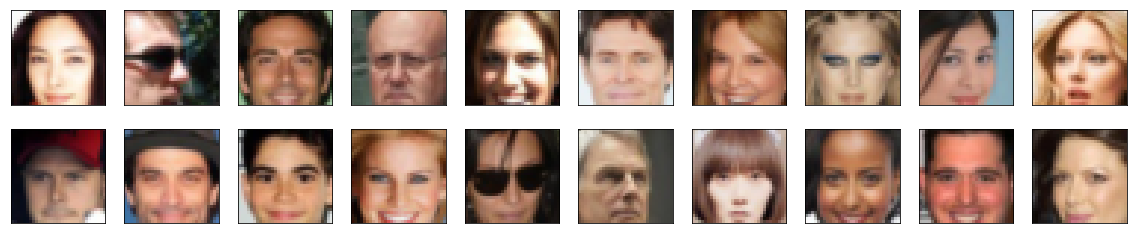

In [11]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
# helper conv function
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [16]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # Convolutional layer stack:
        self.conv1 = conv(         3,  conv_dim, batch_norm=False) # img_size = 32 --> 16
        self.conv2 = conv(  conv_dim,  conv_dim*2)                 # img_size = 16 -->  8
        self.conv3 = conv(conv_dim*2,  conv_dim*4)                 # img_size =  8 -->  4
        
        # Fully-connected output layer:
        self.fc = nn.Linear(in_features=(conv_dim*4)*(4*4), out_features=1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # Convolution
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        # Flatten the output of the conv layers
        x = x.view(-1, (self.conv_dim*4)*(4*4))
        # Final (output) layer
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [18]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.z_size = z_size
        self.conv_dim = conv_dim

        # complete init function
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2)
        self.t_conv2 = deconv(conv_dim*2, conv_dim)
        self.t_conv3 = deconv(conv_dim, 3, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # fully-connected layer:
        x = self.fc(x)
        # reshape before feeding to the transpose conv layers:
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth=conv_dim*4, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = torch.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [19]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, mean=0.0, std=0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        return

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [21]:
# Define model hyperparams
d_conv_dim = 256
g_conv_dim = 256
z_size = 256

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=256, out_features=16384, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), paddin

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [23]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [24]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [25]:
train_on_gpu

True

In [26]:
def make_noise(size, train_on_gpu):
    z = np.random.uniform(-1, 1, size)
    z = torch.from_numpy(z).float() 
    # move z to GPU if available
    if train_on_gpu:
        z = z.cuda()
    return z

In [27]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            G.train()
            D.train()
            
            D.zero_grad()
            G.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            z = make_noise((batch_size, z_size), train_on_gpu)
            if train_on_gpu:
                z = z.cuda()
                real_images = real_images.cuda()
                
            d_loss = real_loss(D(real_images)) + fake_loss(D(G(z)))
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            z = make_noise((batch_size, z_size), train_on_gpu)
            if train_on_gpu:
                z = z.cuda()
            g_loss = real_loss(D(G(z)))
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [28]:
from workspace_utils import active_session

#### Note on the number of epochs

 * After training our GAN on GPU for 2 epochs, the computation time shown by `%%time` is as follows:

`CPU times: user 18min 54s, sys: 12min 42s, total: 31min 36s
Wall time: 31min 38s`
 * So, we can extrapolate that training for 10 epochs (on GPU) should take approximately 2.5 hours.

In [30]:
%%time
# set number of epochs 
n_epochs = 10


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 8.1261 | g_loss: 8.3666
Epoch [    1/   10] | d_loss: 2.9627 | g_loss: 4.3759
Epoch [    1/   10] | d_loss: 1.6493 | g_loss: 2.1570
Epoch [    1/   10] | d_loss: 0.6518 | g_loss: 0.8452
Epoch [    1/   10] | d_loss: 0.2461 | g_loss: 0.5566
Epoch [    1/   10] | d_loss: 0.1738 | g_loss: 1.0772
Epoch [    1/   10] | d_loss: 0.1608 | g_loss: 0.4810
Epoch [    1/   10] | d_loss: 0.2832 | g_loss: 1.0882
Epoch [    1/   10] | d_loss: 0.2692 | g_loss: 0.8832
Epoch [    1/   10] | d_loss: 0.3017 | g_loss: 0.6395
Epoch [    1/   10] | d_loss: 0.2113 | g_loss: 0.4101
Epoch [    1/   10] | d_loss: 0.1489 | g_loss: 0.8347
Epoch [    1/   10] | d_loss: 0.3698 | g_loss: 0.7269
Epoch [    1/   10] | d_loss: 0.3219 | g_loss: 0.3564
Epoch [    1/   10] | d_loss: 0.3060 | g_loss: 0.5296
Epoch [    1/   10] | d_loss: 0.1477 | g_loss: 0.7038
Epoch [    1/   10] | d_loss: 0.2354 | g_loss: 1.4464
Epoch [    1/   10] | d_loss: 0.2455 | g_loss: 0.4155
Epoch [    1/   10] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [31]:
len(losses)

570

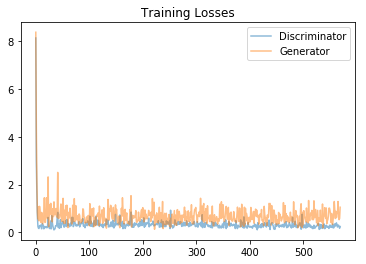

In [32]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [33]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [34]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

# Looking at the results

### Faces generated after training for 1 epoch...
 * The image examples are shown below...
 * __The Good:__ 
     * The images undisputedly resemble human faces
     * The GAN is able to produce a wide variety of very different faces: gender, skin tone, hair color, etc. The fact that it doesn't keep replicating the same face over and over suggests that it actually "understands" what a human face should look like __in general__.
 * __The Bad:__ 
     * The images lack detail; they look like rough sketches of people's faces, rather than actual photos. One obvious issue is a low resolution: even for the 32x32 images, we saw that we can do better than that (see the training image set)
     * By the end of the first epoch, the GAN hasn't quite grasped yet one very important property of a human face: it's symmetry. Many generated faces demonstrate a considerable difference in size and shape of such face features as eyes and brows. Some of the images give an impression that it is two different faces, mashed together (which could still be considered appropriate in say, a horror movie; so perhaps this technique could be used in that line of mass enetertainment...)

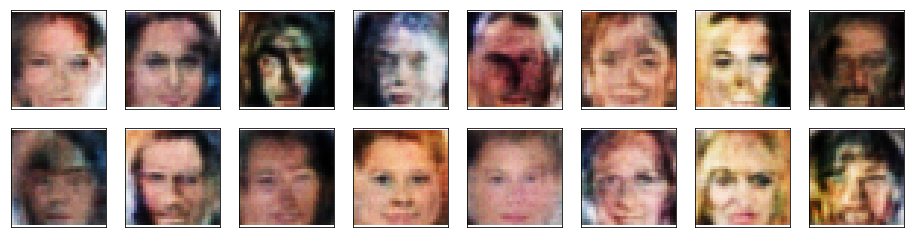

In [38]:
_ = view_samples(0, samples)

### Faces generated after training for 5 epoch...
 * __The Good:__ 
     * By the 5th epoch, the image resolution has improved to a degree, if compared to the previous case.
     * Most faces show a higher degree of symmetry: we observed fewer obvious "freaks".
 * __The Bad:__ 
     * Some images still look like something drawn by Picasso: some face features are occasionally distorted and the overall face proportions are sometimes off. This could mean that the generator still fails to be consistent at producing lifelike images from random noise. But the fact that most faces look quite real gives us hope that training for more epochs will help with this consistency issue.
     * We can sometimes still see that the GAN struggles producing a nice oval of a face: on some pictures, the face edges are blurred to the point that they blend with the background. Once again, a longer traing process might resolve this problem.
 * See the image examples below...

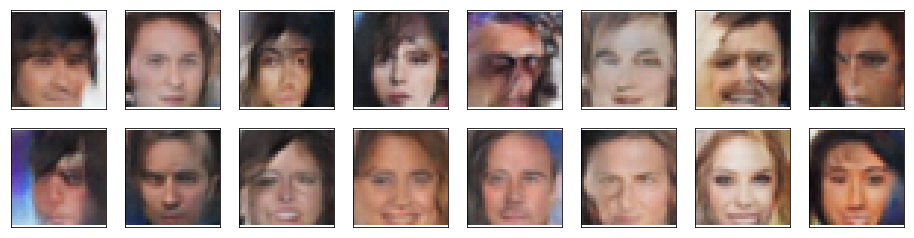

In [37]:
_ = view_samples(4, samples)

### Faces generated after training for 10 epoch...
 * __The Good:__ 
     * By the 10th epoch, almost all "monsters" are gone: the majority of faces look like they could belong to a real human.
     * The resolution has further improved. But at 32x32, this is quite possibly as good as it gets.
 * __The Bad:__ 
     * Some of the faces look somewhat unfinished: an occasional featurte is either missing or lacks clarity; some unnecessary lines and spots are present. It appears that we could train for a bit longer...
 * See the image examples below...

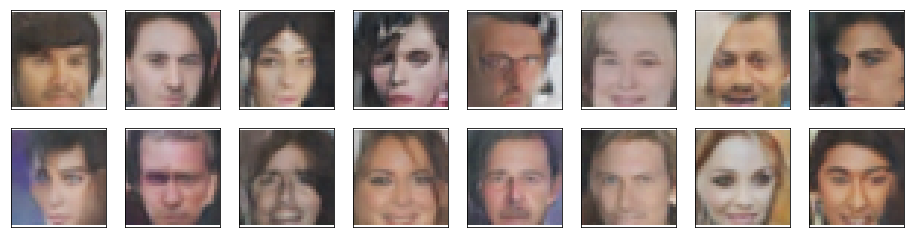

In [36]:
_ = view_samples(9, samples)

In [5]:
# Let's save the checkpoint for the GAN 1.0, trained for 2 epochs, our first (relatively) successful attempt:
# ! cp train_samples.pkl train_samples_gan_v1_2_epochs.pkl

In [4]:
# !ls -lh

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

#### Model architecture and size
 * We used the model architecture utilized in one of the previous projects where we trained a deep convolutional GAN to generate "street view house numbers" based on the [SVHN](http://ufldl.stanford.edu/housenumbers/) dataset.
 * The __Discriminator__ has 3 convolutional layers (with batch normalization in the last two) with a kernel size 4 and stride 2, followed by a fully connected layer that produces a single value ("real/fake" binary classifier) as a final output.
 * The __Generator's__ architecture generally looks like a mirror reflection of the Discriminator: it begins with a fully connected layer that gets its input from a noise vector `z` (which provides a "seed" for a random process of face generation). Then, after being reshaped the output of that layer is passed to 3 consecutive transpose convolutional layers that upsample the seed "image" while introducing more detail to it.
 * __Depth of the convolutional layers:__ We saw earlier in the SVHN project that having 32 filters in the first convolutional layer (and then doubling that number in each subsequent convolutional layer) lead to fairly good results. However, even after training the GAN for 50 epochs, the produced images of the house numbers were quite grainy, with a lot of poorly rendered digits. This suggested that the model lacked complexity, which ultimately limited its ability to capture some high-level features (patterns). One obvious way to mitigate this shortcoming is to increase the depth of the convolutional layers. So for our human face generating GAN, we set the hyperparameter `conv_dim` at 256 for both "adversaries": Generator and Discriminator.
 
#### Optimization strategy
 * We used the MSE loss function as it has been reported to add more stability to the training process and even increase the speed of learning.
 * We used the Adam optimizer, a popular choice in GAN training projects. We used the hyperparameters recommended in the in the recent publications
     * `lr=0.0002`
     * `beta1=0.5`
     * `beta2=0.999`
 * The graph of the training losses (for both Generator and Discriminator) as functions of the training iterations demonstrates a good dynamic: 
     * Initially the loss of both Generator and Discriminator is very high: neither of them yet "understands" what a human face is like.
     * Over the course of a few first iterations, both losses drop drastically. After that initial drop, they continue to oscillate in a relatively narrow range. This could mean that our GAN has reached a type of equilibrium: both adversaries have learned enough to understand what a human face is about and now, "the devil is in details". 
     * In case of the adversarial training, such oscillations are as close as any GAN can get to a convergence. Both adversaries continue to try to outperform their respective counterpart so a certain amount of loss oscillation is to be expected, regardless of the number of training epochs.
     * The consistent behavior of both loss functions (mainly, absence of violent loss swings) suggests that the optimization strategy (type of optimizer, as well as the hyperparameter values) has been chosen correctly.
 * __Number of epochs:__ The obtained results were quite encouraging: after training the GAN for just one epoch, our model was able to produce images that undeniably resembled human faces. There were however some obvious issues. The two most prominent shortcomings were:
     * Low resolution: all images were very pixelated. It has been mentioned in class that low resolution is one of the well-known outstanding issues with GAN's. 
     * After 5 epochs, our model was still occasionally failing to capture one very important property of all human faces, namely face symmetry. Some of the generated images were highly asymmetric, with very different sizes of eyes, brows, inconsistent hair color, etc.
     * By epoch 10, the overall image quality has notably improved. However, if compared to the results of the epoch 5, the difference, though considerable is not drastics. This suggets that by epoch 10, our model is approaching its limitations.
     
 * Based on the obatined results and the overall progress in the image rendering, one should expect that the GAN performance __could be somewhat improved by increasing the training time (number of epochs)__. 
 
#### Limitations imposed by the dataset
 * Having a mostly-white human face dataset definitely introduces a bias to the training process. 
 * This issue has a lot in common with a well-known problem of unballanced datasets in supervised learning: if the distribution of examples for different classes is very scewed then the model (known as a classifier) will end up being biased toward the dominant class. 
 * It appears that our GAN did not get a chance to learn enough about all possible skin colors and thus, it "assumes" that the faces are almost always white. 
 * Therefore, one would expect that introducing more racial diversity in the training dataset should largely eliminate this bias, thereby fixing this issue.
 
#### Final thoughts on possible ways to improve the model
 * Even though it looks like we could get better images if we trained our GAN a bit longer (perhaps, as long as 20 epochs), the decreasing difference between the results produced by consecutive epochs suggests that by the epoch 10, we are not far from our model's limits. So in order to __considerably__ improve the quality of the generated images, one would probably have to redesign the GAN architecture: add more convolutional layers, increase the layer depth, etc.
 * It would be especially interesting to add a few __residual blocks__ to our Generator. We saw earlier that these elements are a crucial part of the CycleGAN's. So it is quite possible that adding residual blocks would help our GAN capture some of the finer face features and thus, enable the model to generate the images that are more lifelike. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.